<a href="https://colab.research.google.com/github/GeetanjaliBihani/twitter_analysis/blob/master/Shopping_tweets_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1I2NCXyRHeQfoDO9L-_8n6A3V8PyXGfOD"})   # replace the id with id of file you want to access
downloaded.GetContentFile('streamer_20200210-040421.json') 

In [ ]:
# # Import package
import tweepy
import json
import re
from tweepy import StreamListener
from tweepy import OAuthHandler
from tweepy import API
import time
import nltk

# #Replace twitter credentials
# consumer_key = "Phyhot6wiPUmBd8KMsbndkJVR"
# consumer_secret = "09pm8OZoUEPSknTr0RrqmJyjpmAHQNP9yGTVNBNEVNbBe0R3cz"
# access_token_key = "326374572-VpyShnjFdpTOj0PpkazoDvc0Wry2Ksgfw3S8RIh1"
# access_token_secret = "cX74gfCwb8wB33xyCkqnXVZJcdaF6i7sQ5dvzihZpUkU9"

# # Pass OAuth details to tweepy's OAuth handler
# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token_key, access_token_secret)

In [ ]:
# #creating a new listener class (as taught by Alex Hanna)
# from tweepy import StreamListener
# class SListener(StreamListener):
#     def __init__(self, api = None, fprefix = 'streamer'):
#         self.api = api or API()
#         self.counter = 0
#         self.fprefix = fprefix
#         self.output  = open('%s_%s.json' % (self.fprefix, time.strftime('%Y%m%d-%H%M%S')), 'w')


#     def on_data(self, data):
#         if  'in_reply_to_status' in data:
#             self.on_status(data)
#         elif 'delete' in data:
#             delete = json.loads(data)['delete']['status']
#             if self.on_delete(delete['id'], delete['user_id']) is False:
#                 return False
#         elif 'limit' in data:
#             if self.on_limit(json.loads(data)['limit']['track']) is False:
#                 return False
#         elif 'warning' in data:
#             warning = json.loads(data)['warnings']
#             print("WARNING: %s" % warning['message'])
#             return


#     def on_status(self, status):
#         self.output.write(status)
#         self.counter += 1
#         if self.counter >= 20000:
#             self.output.close()
#             self.output  = open('%s_%s.json' % (self.fprefix, time.strftime('%Y%m%d-%H%M%S')), 'w')
#             self.counter = 0
#         return


#     def on_delete(self, status_id, user_id):
#         print("Delete notice")
#         return


#     def on_limit(self, track):
#         print("WARNING: Limitation notice received, tweets missed: %d" % track)
#         return


#     def on_error(self, status_code):
#         print('Encountered error with status code:', status_code)
#         return 


#     def on_timeout(self):
#         print("Timeout, sleeping for 60 seconds...")
#         time.sleep(60)
#         return 

In [ ]:
# api  = tweepy.API(auth)

# # Initialize Stream listener
# l = SListener()

# # Create your Stream object with authentication
# stream = tweepy.Stream(auth, l)

# # Filter Twitter Streams to capture data by the keywords:
# stream.filter(track = ['shopping'])
# # stream.sample()

In [ ]:
import glob
import pandas as pd
import numpy as np
list(glob.iglob('streamer*.json'))

['streamer_20200210-040421.json']

In [ ]:
import glob
import pandas as pd
import numpy as np

#extracting tweets
files  = list(glob.iglob('streamer*'))
# +(list(glob.iglob('streamer_20200210-0753*')))

In [ ]:
for f in files:
    fh = open(f, 'r', encoding = 'utf-8')
    tweets_json = fh.read().split("\n")

    ## remove empty lines
    tweets_json = list(filter(len, tweets_json))

    ## parse each tweet
    for tweet in tweets_json:
        try:
            tweet_obj = json.loads(tweet)

            ## flatten the file to include quoted status and retweeted status info
            if 'quoted_status' in tweet_obj:
                tweet_obj['quoted_status-text'] = tweet_obj['quoted_status']['text'] 
                tweet_obj['quoted_status-user-screen_name'] = tweet_obj['quoted_status']['user']['screen_name']
                tweet_obj['quoted_status-extended_tweet-full_text'] = tweet_obj['quoted_status']['extended_tweet']['full_text']

            if 'retweeted_status' in tweet_obj:
                tweet_obj['retweeted_status-user-screen_name'] = tweet_obj['retweeted_status']['user']['screen_name']
                tweet_obj['retweeted_status-text'] = tweet_obj['retweeted_status']['text']
                tweet_obj['retweeted_status-extended_tweet-full_text'] = tweet_obj['retweeted_status']['extended_tweet']['full_text']
            
            if 'extended_tweet' in tweet_obj:
                tweet_obj['extended_tweet-full_text'] = tweet_obj['extended_tweet']['full_text']


            tweet_obj['user-screen_name'] = tweet_obj['user']['screen_name']
            tweet_obj['user-location']=tweet_obj['user']['location']

            tweets.append(tweet_obj)
        except:
            pass

In [ ]:
## create pandas DataFrame for further analysis
df_tweet = pd.DataFrame(tweets)

In [ ]:
df_tweet.tail()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,quote_count,reply_count,retweet_count,favorite_count,entities,favorited,retweeted,possibly_sensitive,filter_level,lang,timestamp_ms,user-screen_name,user-location,extended_tweet,extended_tweet-full_text,retweeted_status,retweeted_status-user-screen_name,retweeted_status-text,retweeted_status-extended_tweet-full_text,display_text_range,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,quoted_status-text,quoted_status-user-screen_name,quoted_status-extended_tweet-full_text
3024,Mon Feb 10 10:19:27 +0000 2020,1226812919800721409,1226812919800721409,Join @TopCashBackUSA and get money back on you...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,NaN,None,NaN,None,None,"{'id': 1226458537485721601, 'id_str': '1226458...",None,None,None,None,False,0,0,0,0,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",False,False,False,low,en,1581329967819,Hiu89580572,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3025,Mon Feb 10 10:19:29 +0000 2020,1226812928814395392,1226812928814395392,Now go shopping from our biggest stores noon a...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",True,NaN,None,NaN,None,None,"{'id': 3193544283, 'id_str': '3193544283', 'na...",None,None,None,None,False,0,0,0,0,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",False,False,False,low,ca,1581329969968,bander67612,Riyadh,{'full_text': 'Now go shopping from our bigges...,Now go shopping from our biggest stores noon a...,NaN,NaN,NaN,NaN,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3026,Mon Feb 10 10:19:35 +0000 2020,1226812952315092993,1226812952315092993,Pamela te espera para que comiences relax la s...,"<a href=""http://twitter.com/download/android"" ...",True,NaN,None,NaN,None,None,"{'id': 836358065351897089, 'id_str': '83635806...",None,None,None,None,False,0,0,0,0,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",False,False,False,low,es,1581329975571,lunamendez6969,"Paraguari, Paraguay",{'full_text': 'Pamela te espera para que comie...,Pamela te espera para que comiences relax la s...,NaN,NaN,NaN,NaN,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3027,Mon Feb 10 10:19:38 +0000 2020,1226812963216117761,1226812963216117761,"Win a $1,000 BlanQuil Shopping Spree https://t...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,NaN,None,NaN,None,None,"{'id': 2344983606, 'id_str': '2344983606', 'na...",None,None,None,None,False,0,0,0,0,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",False,False,False,low,en,1581329978170,MzBeeBeeTweets,Midwest America,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3028,Mon Feb 10 10:19:38 +0000 2020,1226812965585870853,1226812965585870853,Enter to win @LotusTrolleyBag Reusable Grocery...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,NaN,None,NaN,None,None,"{'id': 370907906, 'id_str': '370907906', 'name...",None,None,None,None,False,0,0,0,0,"{'hashtags': [{'text': 'giveaway', 'indices': ...",False,False,False,low,en,1581329978735,macdrap50,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#proportion of tweet languages
from collections import Counter
import numpy as np
lang_counts = Counter(df_tweet['lang'])
lang_counts = pd.DataFrame(lang_counts.most_common(), columns = ['lang', 'count'])
lang_counts['propn'] = (lang_counts['count']/sum(lang_counts['count']))*100
lang_counts

,lang,count,propn
0,en,1984,65.500165
1,ja,496,16.375041
2,in,161,5.315286
3,pt,97,3.202377
4,ca,43,1.419610
5,und,43,1.419610
6,fr,31,1.023440
7,ar,30,0.990426
8,es,28,0.924397
9,tl,19,0.627270


In [ ]:
#analyzing twitter data
#english tweets
df_tweet_en = df_tweet[df_tweet['lang']=='en']

In [ ]:
length = len(df_tweet_en)
print('We are analyzing {} English tweets'.format(length))

We are analyzing 1984 English tweets


In [ ]:
#combining all tweets into one blob
text = " ".join(i for i in df_tweet_en.text)

text = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', text)

from nltk.corpus import stopwords
from tokenize import tokenize
import string
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('stopwords')
tokenizer = RegexpTokenizer(r'\w+')
import itertools

stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['shopping', 'http','rt', 'https', 'co']
for i in newStopWords:
    stopwords.append(i)
    
text1 = df_tweet_en.apply(lambda row: tokenizer.tokenize(row['text']), axis=1)
text2 = list(itertools.chain(*text1))
text3 = [tweet.strip(' ').lower() for tweet in text2]        
text4 = [tweet for tweet in text3 if tweet not in stopwords]
# text5 = " ".join(i for i in text4)

# text5 = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', text4)

# # List of all words across tweets
# import itertools


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Create counter
import collections
text6 = []
for i in text4:
  word_cleaned = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', i)
  text6.append(word_cleaned)

# text5 = " ".join(re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', i) for i in text4)

counts = collections.Counter(text6)
top10 = counts.most_common(10)
text7 = " ".join(i for i in text6)

In [ ]:
top10 = pd.DataFrame(top10, columns = ['word', 'count'])

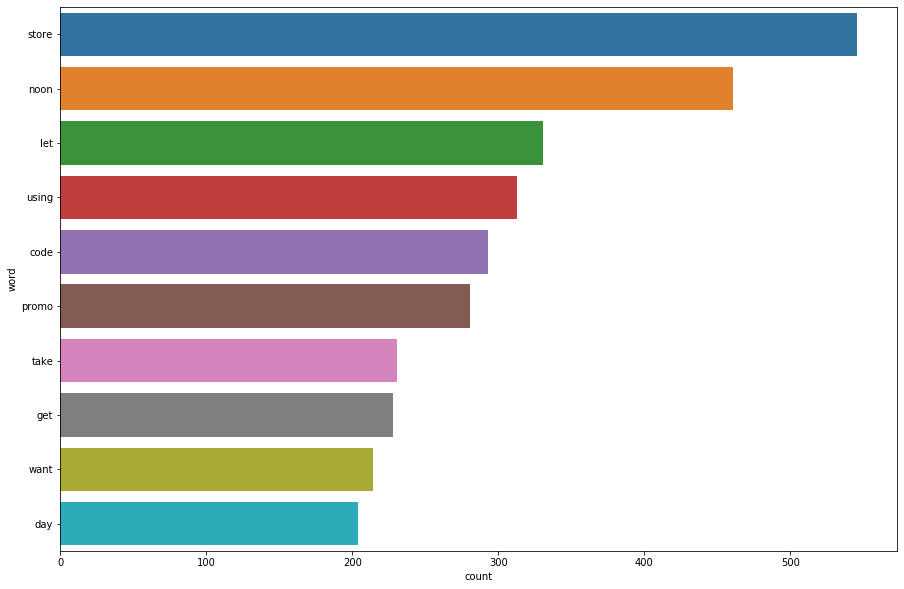

In [ ]:
import seaborn as sns
from matplotlib.pyplot import figure

figure(figsize=(15,10))
ax = sns.barplot(x = top10['count'], y = top10['word'])

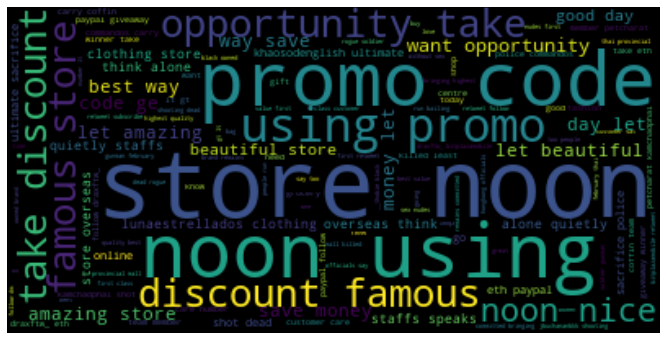

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

# Generate a word cloud image
wordcloud = WordCloud(stopwords=STOPWORDS).generate(text7)
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6))
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# #printing top 10 tweets
print(df_tweet_en["text"].head(10))

2     RT @sugardaddyhens: I'm legit #sugardaddydatin...
4     Yonglish\n lesson3 : "When you go shopping"\n#...
5     RT @Xquisite_Store: #Ad 🚨 We're Turning Up The...
6     @SteveCaple4 Looks like that's what will happe...
7     Ganstalking  continues unabated always in shop...
10    Emma Shirt\nAvailable 3 colors\n• Off White\n•...
12    RT @TheGrangeCentre: We’ve started a Grange Wa...
13    RT @FunAussieFilms: It's so funny to see what ...
14    @franamadi @obiakoconstance Mr uzor traveled f...
16    "If you want to do shopping here is an opportu...
Name: text, dtype: object


In [ ]:
#tweets over time
#time series analysis
# Print created_at to see the original format of datetime in Twitter data
print(df_tweet_en['created_at'].head())

# Convert the created_at column to np.datetime object
df_tweet_en['created_at'] = pd.to_datetime(df_tweet_en['created_at'])

# Print created_at to see new format
print(df_tweet_en['created_at'].head())

# Set the index of ds_tweets to created_at
df_tweet_en = df_tweet_en.set_index('created_at')

2    Mon Feb 10 09:04:21 +0000 2020
4    Mon Feb 10 09:04:24 +0000 2020
5    Mon Feb 10 09:04:25 +0000 2020
6    Mon Feb 10 09:04:29 +0000 2020
7    Mon Feb 10 09:04:30 +0000 2020
Name: created_at, dtype: object
2   2020-02-10 09:04:21+00:00
4   2020-02-10 09:04:24+00:00
5   2020-02-10 09:04:25+00:00
6   2020-02-10 09:04:29+00:00
7   2020-02-10 09:04:30+00:00
Name: created_at, dtype: datetime64[ns, UTC]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
max(df_tweet_en.index) - min(df_tweet_en.index)

Timedelta('0 days 01:15:17')

In [ ]:
# Load SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Instantiate new SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Generate sentiment scores
sentiment_scores = df_tweet_en['text'].apply(sid.polarity_scores)
sentiment = sentiment_scores.apply(lambda x: x['compound'])
sentiment = sentiment.resample('1T').mean()
# Generate average sentiment scores for #word
# sentiment1 = sentiment[check_word_in_tweet('indian', df_tweet_en)].resample('15s').mean()
# sentiment2 = sentiment[check_word_in_tweet('elections', df_tweet_en)].resample('15s').mean()
# sentiment3 = sentiment[check_word_in_tweet('india', df_tweet_en)].resample('15s').mean()
# sentiment4 = sentiment[check_word_in_tweet('aadhar', df_tweet_en)].resample('15s').mean()
# sentiment5 = sentiment[check_word_in_tweet('vikassaraswat', df_tweet_en)].resample('15s').mean()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


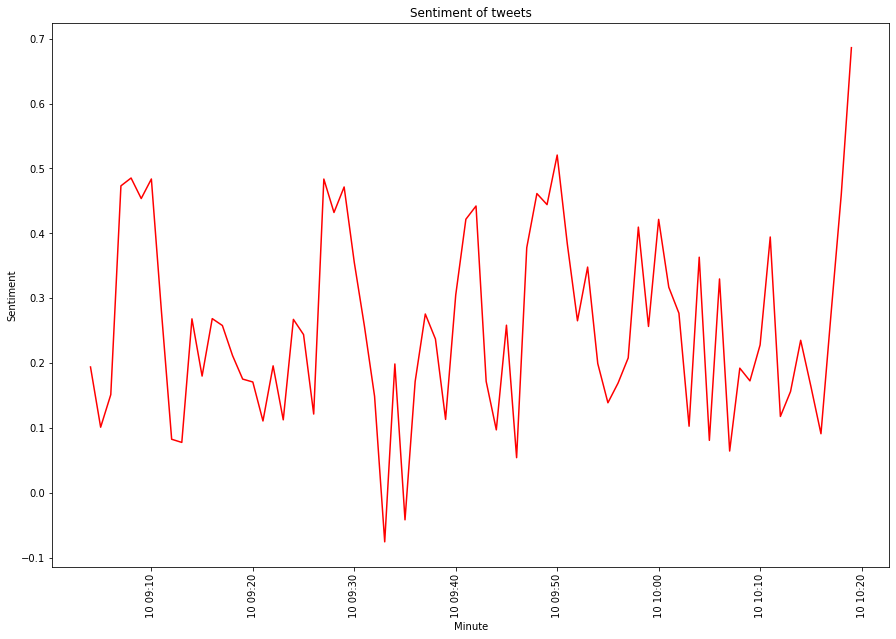

In [ ]:
import matplotlib.pyplot as plt

# Plot average #wuhan sentiment per day
figure(figsize=(15,10))

plt.plot(sentiment.index, sentiment, color = 'red')
plt.xlabel('Minute')
plt.ylabel('Sentiment')
plt.title('Sentiment of tweets')
plt.xticks(rotation=90)
plt.show()

In [ ]:
def check_word_in_tweet(word, data):
    """Checks if a word is in a Twitter dataset's text. 
    Checks text and extended tweet (140+ character tweets) for tweets,
    retweets and quoted tweets.
    Returns a logical pandas Series.
    """
    contains_column = data['text'].str.contains(word, case = False)
    contains_column |= data['extended_tweet-full_text'].str.contains(word, case = False)
    contains_column |= data['quoted_status-text'].str.contains(word, case = False)
    contains_column |= data['quoted_status-extended_tweet-full_text'].str.contains(word, case = False)
    contains_column |= data['retweeted_status-text'].str.contains(word, case = False)
    contains_column |= data['retweeted_status-extended_tweet-full_text'].str.contains(word, case = False)
    return contains_column

In [ ]:
#fill all na/nan values with NA
df_tweet_en_n = df_tweet_en.fillna('NA')

In [ ]:
#filter for tweets with retweets; tweets with replies
df_tweet_en_rt = df_tweet_en_n[df_tweet_en_n['retweeted_status-user-screen_name']!='NA']
df_tweet_en_reply = df_tweet_en_n[df_tweet_en_n['in_reply_to_screen_name']!='NA']


In [ ]:
# network
# Import networkx
import networkx as nx

# Create retweet network from edgelist
G_rt = nx.from_pandas_edgelist(
    df_tweet_en_rt,
    source = 'user-screen_name',
    target = 'retweeted_status-user-screen_name', edge_attr = None,
    create_using = nx.DiGraph())
 
# Print the number of nodes
print('Nodes in RT network:', len(G_rt.nodes()))

# Print the number of edges
print('Edges in RT network:', len(G_rt.edges()))

# Import networkx
import networkx as nx

# Create reply network from edgelist
G_reply = nx.from_pandas_edgelist(
    df_tweet_en_reply,
    source = 'user-screen_name',
    target = 'in_reply_to_screen_name', edge_attr = None,
    create_using = nx.DiGraph())
    
# Print the number of nodes
print('Nodes in reply network:', len(G_reply.nodes()))

# Print the number of edges
print('Edges in reply network:', len(G_reply.edges()))

Nodes in RT network: 906
Edges in RT network: 703
Nodes in reply network: 314
Edges in reply network: 174


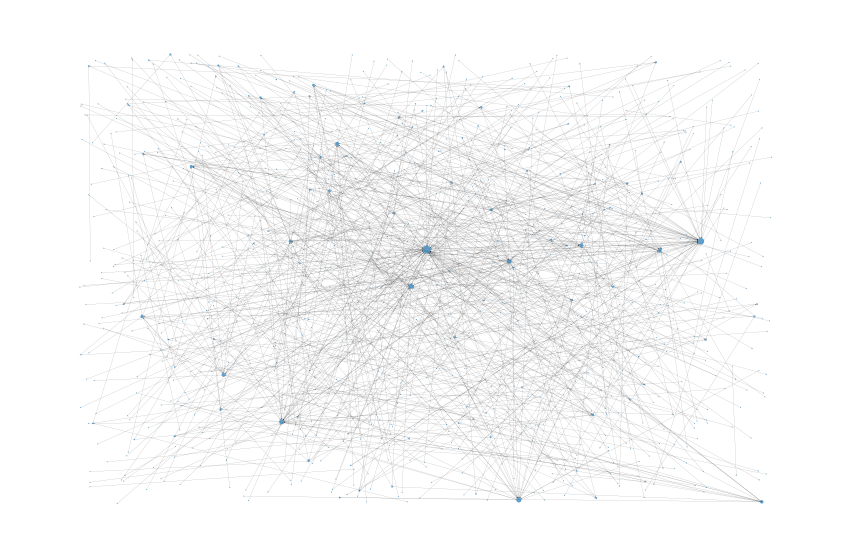

In [ ]:
# Create random layout positions
#retweet
pos = nx.random_layout(G_rt)

# Create size list
sizes = [x[1] for x in G_rt.degree()]

figure(figsize=(15,10))

# Draw the network
nx.draw_networkx(G_rt, pos,
    with_labels = False, 
    node_size = sizes,
    width = 0.1, alpha = 0.7,
    arrowsize = 1, linewidths = 0)

# Turn axis off and show
plt.axis('off'); plt.show()

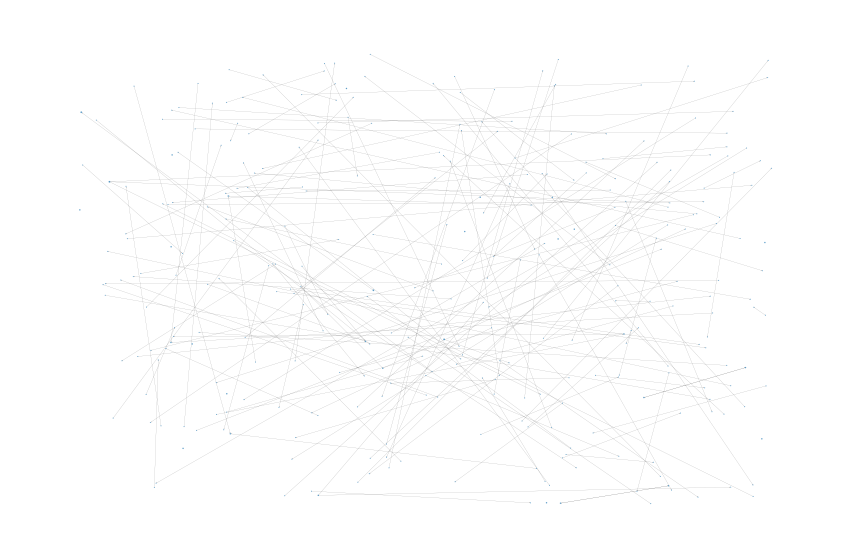

In [ ]:
# Create random layout positions
#reply
pos = nx.random_layout(G_reply)

# Create size list
sizes = [x[1] for x in G_reply.degree()]

figure(figsize=(15,10))

# Draw the network
nx.draw_networkx(G_reply, pos,
    with_labels = False, 
    node_size = sizes,
    width = 0.1, alpha = 0.7,
    arrowsize = 1, linewidths = 0)

# Turn axis off and show
plt.axis('off'); plt.show()

In [ ]:
# Generate in-degree centrality for retweets 
rt_centrality = nx.in_degree_centrality(G_rt)

# Generate in-degree centrality for replies 
reply_centrality = nx.in_degree_centrality(G_reply)

column_names = ['screen_name', 'degree_centrality']

# Store centralities in DataFrame
rt = pd.DataFrame(list(rt_centrality.items()), columns = column_names)
reply = pd.DataFrame(list(reply_centrality.items()), columns = column_names)

# Print first five results in descending order of centrality
print(rt.sort_values('degree_centrality', ascending = False).head())

# Print first five results in descending order of centrality
print(reply.sort_values('degree_centrality', ascending = False).head())

# Generate betweenness centrality for retweets 
rt_centrality = nx.betweenness_centrality(G_rt)

# Generate betweenness centrality for replies 
reply_centrality = nx.betweenness_centrality(G_reply)

# Store centralities in data frames
rt = pd.DataFrame(list(rt_centrality.items()), columns = ['screen_name', 'betweenness_centrality'])
reply = pd.DataFrame(list(reply_centrality.items()), columns = ['screen_name', 'betweenness_centrality'])

# Print first five results in descending order of centrality
print(rt.sort_values('betweenness_centrality', ascending = False).head())

# Print first five results in descending order of centrality
print(reply.sort_values('betweenness_centrality', ascending = False).head())

         screen_name  degree_centrality
260  lunaestrellados           0.069613
16    KhaosodEnglish           0.048619
288         DraxFTW_           0.027624
560     JBuchananBKK           0.027624
664         __Thobie           0.026519
    screen_name  degree_centrality
72      rypaffo            0.00639
263     mo3taz1            0.00639
33   JohnnyTYKE            0.00639
153  Femi_Sorry            0.00639
46   Webster_IM            0.00639
         screen_name  betweenness_centrality
294   thebetterindia                0.000023
441         SanchPal                0.000010
82      savory_tales                0.000005
402    PirateMulwana                0.000005
685  GlasgowCityDeal                0.000002
         screen_name  betweenness_centrality
128            Tesco                 0.00001
0            Rhys998                 0.00000
213       polldoodle                 0.00000
212  LadyWrites_Blog                 0.00000
211    nicolalondors                 0.00000


In [ ]:
#text analysis further
### Convert to list, remove new line characters
#complaints
import gensim
import re
data1 = df_tweet_en["text"].values.tolist()
data1 = [re.sub('\s+', ' ', sent) for sent in data1]
data1 = [str(sent) for sent in data1]


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words1 = list(sent_to_words(data1))

print(data_words1[:1])

# # Build the bigram models
bigram1 = gensim.models.Phrases(data_words1, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod1 = gensim.models.phrases.Phraser(bigram1)

# Define functions for stopwords, bigrams, trigrams and lemmatization
# NLTK Stop words
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'shopping', 'http','rt', 'https', 'co'])

def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams1(texts):
    return [bigram_mod1[doc] for doc in texts]
def make_bigrams2(texts):
    return [bigram_mod2[doc] for doc in texts]
def make_bigrams3(texts):
    return [bigram_mod3[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops1 = remove_stopwords(data_words1)

# # Form Bigrams
data_words_bigrams1 = make_bigrams1(data_words_nostops1)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
import spacy
# python3 -m spacy download en

nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized1 = lemmatization(data_words_bigrams1, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


print(data_lemmatized1[:1])

[['rt', 'sugardaddyhens', 'legit', 'and', 'in', 'need', 'of', 'sugarbaby', 'girls', 'who', 'is', 'willing', 'to', 'have', 'this', 'weekend', 'for', 'shopp']]
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[['sugardaddyhen', 'legit', 'need', 'sugarbaby', 'girl', 'willing', 'weekend', 'shopp']]


In [ ]:
#creating dictionaries
import gensim
dictionary1 = gensim.corpora.Dictionary(data_lemmatized1)
count = 0
print('dictonary1')
for k, v in dictionary1.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

dictonary1
0 girl
1 legit
2 need
3 shopp
4 sugarbaby
5 sugardaddyhen
6 weekend
7 willing
8 cbp
9 go
10 lesson


In [ ]:
#create bow representation of words
bow_corpus1 = [dictionary1.doc2bow(doc) for doc in data_lemmatized1]

#creating tfidf representations
from gensim import corpora, models
tfidf1 = models.TfidfModel(bow_corpus1)
corpus_tfidf1 = tfidf1[bow_corpus1]
from pprint import pprint
for doc in corpus_tfidf1:
    pprint(doc)
    break

[(0, 0.29757750359537016),
 (1, 0.42709746302137785),
 (2, 0.23041959914056678),
 (3, 0.33656689641978027),
 (4, 0.38810807019696775),
 (5, 0.42709746302137785),
 (6, 0.31012928454814753),
 (7, 0.36530073746880126)]


In [ ]:
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [ ]:
# Can take a long time to run.
import gensim 
from gensim.models import CoherenceModel
model_list1, coherence_values1 = compute_coherence_values(dictionary=dictionary1, corpus=bow_corpus1, texts=data_lemmatized1, start=2, limit=20, step=2)

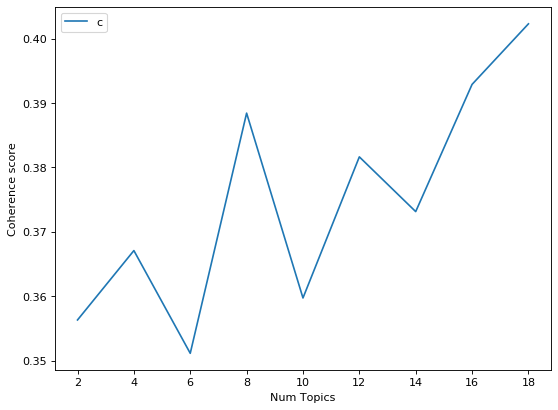

In [ ]:
# Show graph complaint topics
import matplotlib.pyplot as plt
%matplotlib inline
limit=20; start=2; step=2;
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
x = range(start, limit, step)
plt.plot(x, coherence_values1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
#running lda model 
import gensim
lda_model1 = gensim.models.LdaMulticore(bow_corpus1, num_topics=8, id2word=dictionary1, passes=2, workers=2)

In [ ]:
#explore each topic
for idx, topic in lda_model1.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.018*"shot_dead" + 0.016*"ultimate_sacrifice" + 0.016*"team_member" + 0.016*"carry_coffin" + 0.016*"police_commandos" + 0.016*"petcharat_kamchadphai" + 0.016*"khaosodenglish" + 0.013*"people" + 0.010*"get" + 0.007*"know"
Topic: 1 
Words: 0.054*"store" + 0.054*"noon" + 0.046*"use" + 0.045*"let" + 0.044*"good" + 0.042*"code" + 0.041*"promo" + 0.023*"get" + 0.023*"beautiful" + 0.022*"day"
Topic: 2 
Words: 0.034*"store" + 0.021*"think" + 0.020*"clothing" + 0.020*"alone_quietly" + 0.020*"overseas" + 0.019*"staffs_speak" + 0.019*"lunaestrellados" + 0.016*"want" + 0.015*"take" + 0.014*"nice"
Topic: 3 
Words: 0.014*"use" + 0.013*"code" + 0.012*"store" + 0.012*"good" + 0.012*"let" + 0.011*"take" + 0.011*"promo" + 0.010*"way" + 0.010*"amazing" + 0.010*"save_money"
Topic: 4 
Words: 0.013*"shoe" + 0.007*"get" + 0.007*"go" + 0.007*"day" + 0.006*"literally" + 0.006*"rn_decide" + 0.006*"kend" + 0.005*"mall" + 0.005*"thank" + 0.005*"leave"
Topic: 5 
Words: 0.021*"go" + 0.011*"online"

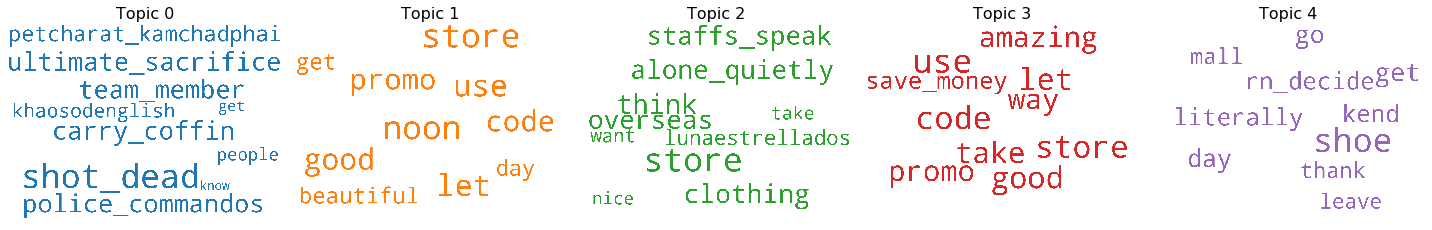

In [ ]:
##Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model1.show_topics(formatted=False)

fig, axes = plt.subplots(1,5, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords1 = format_topics_sentences(ldamodel=lda_model1, corpus=bow_corpus1, texts=data1)

# Format
df_dominant_topic1 = df_topic_sents_keywords1.reset_index()
df_dominant_topic1.columns = ['Document_No', 'Topic1', 'Topic_contri1', 'Keywords1', 'Complaint']

# Show
df_dominant_topic1.head(10)

,Document_No,Topic1,Topic_contri1,Keywords1,Complaint
0,0,1.0,0.9027,"store, noon, use, let, good, code, promo, get,...",RT @sugardaddyhens: I'm legit #sugardaddydatin...
1,1,2.0,0.9125,"store, think, clothing, alone_quietly, oversea...","Yonglish lesson3 : ""When you go shopping"" #MAM..."
2,2,4.0,0.9271,"shoe, get, go, day, literally, rn_decide, kend...",RT @Xquisite_Store: #Ad 🚨 We're Turning Up The...
3,3,3.0,0.6068,"use, code, store, good, let, take, promo, way,...",@SteveCaple4 Looks like that's what will happe...
4,4,3.0,0.9375,"use, code, store, good, let, take, promo, way,...",Ganstalking continues unabated always in shopp...
5,5,1.0,0.9374,"store, noon, use, let, good, code, promo, get,...",Emma Shirt Available 3 colors • Off White • Ca...
6,6,7.0,0.9374,"thank, follow, shop, get, amp, go, valentine, ...",RT @TheGrangeCentre: We’ve started a Grange Wa...
7,7,0.0,0.9270,"shot_dead, ultimate_sacrifice, team_member, ca...",RT @FunAussieFilms: It's so funny to see what ...
8,8,0.0,0.7549,"shot_dead, ultimate_sacrifice, team_member, ca...",@franamadi @obiakoconstance Mr uzor traveled f...
9,9,6.0,0.8088,"nice, store, take, discount, noon, want, oppor...","""If you want to do shopping here is an opportu..."


In [ ]:
#topic distribution visualization
#for complaints topic model
# !pip install pyLDAvis
import pyLDAvis
from pyLDAvis import gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model1, bow_corpus1, dictionary1)
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


NameError: ignored

In [ ]:
pyLDAvis.save_html(vis, 'shopper_clusters.html')

In [ ]:
from google.colab import files
files.download('shopper_clusters.html') 